In [1]:
import nibabel as nib


In [5]:
img = nib.load('DATA/alff/ASD/KKI_0050792_alff.nii.gz')
arr = img.get_fdata()
arr.shape

(61, 73, 61)

[]

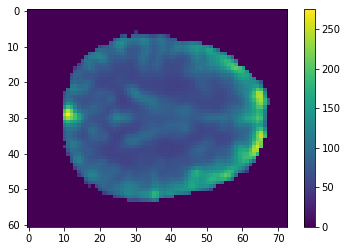

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(arr[:,:,31])
plt.colorbar()
plt.plot()


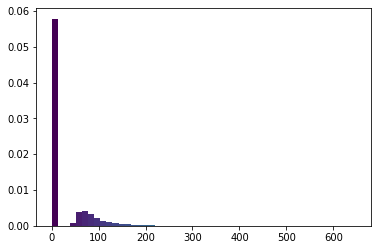

In [37]:
import numpy as np
from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()
    
show_histogram(arr)

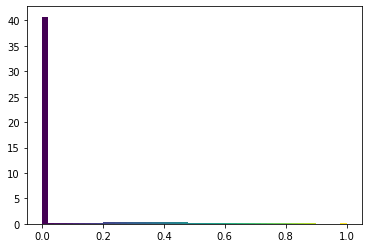

In [38]:
def scale_by(arr, fac):
    mean = np.mean(arr)
    return (arr-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(arr)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)
show_histogram(transformed)


In [39]:
from nilearn import plotting

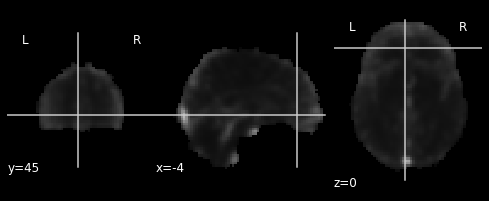

In [63]:
plotting.plot_anat(img)

In [65]:
plotting.plot_glass_brain(img, threshold=3, colorbar=True,
                          title='Brain glass image of ASD',
                          display_mode='lyrz',
                         resampling_interpolation='neirest',
                          output_file='ASD_glass_brain')

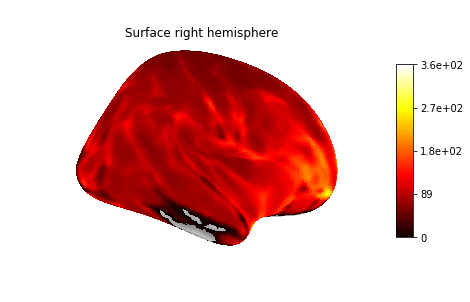

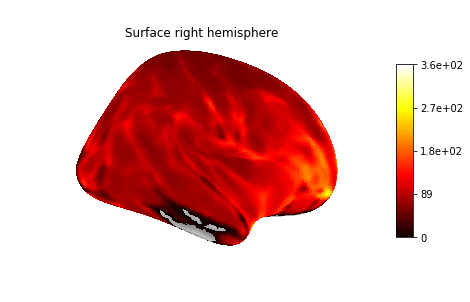

In [60]:
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(img, fsaverage.pial_right)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=1., bg_map=fsaverage.sulc_right)

In [14]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.savefig('3Dslice.png')
    plt.show()
    


In [26]:
IMG_DIM = 61

from skimage.transform import resize
resized = resize(transformed, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')


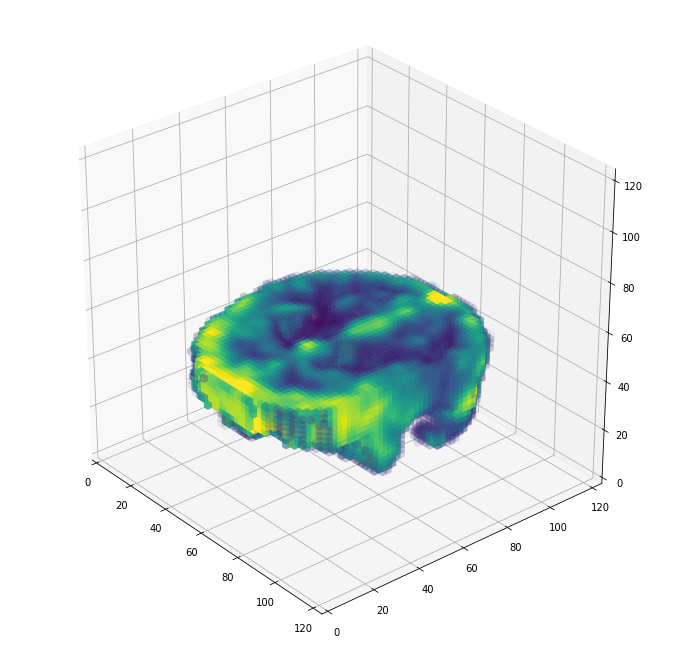

In [27]:
plot_cube(resized[:48,::-1,:27])

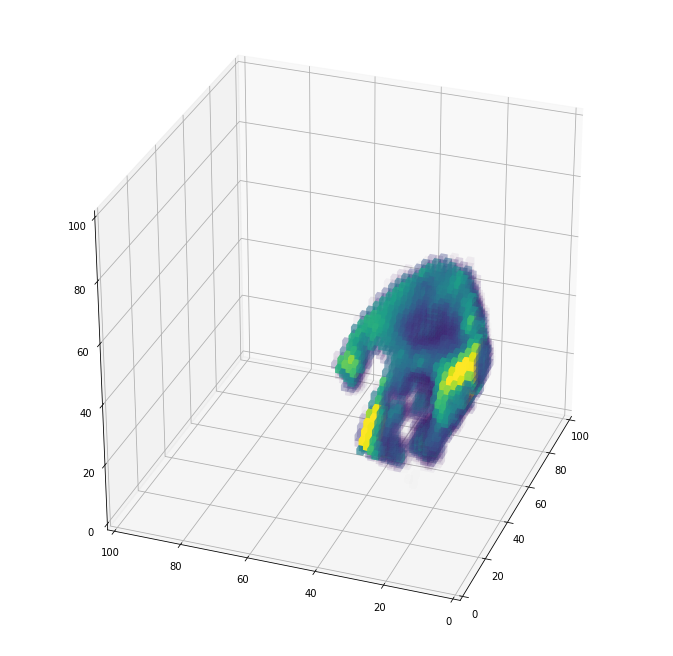

In [22]:
cube = np.copy(resized)

for x in range(0, IMG_DIM):
    for y in range(0, IMG_DIM):
        for z in range(max(x-y+2, 0), IMG_DIM):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)